Dataset loaded. Shape: (100, 14)

First few rows:
   Year  Smoking_Population_Percentage  Male_Smokers_Percentage  \
0  1924                             25                     15.0   
1  1925                             26                     15.6   
2  1926                             27                     16.2   
3  1927                             28                     16.8   
4  1928                             29                     17.4   

   Female_Smokers_Percentage  Smoking_Related_Deaths  Country      City  \
0                       10.0                  152267      USA  New York   
1                       10.4                  960004       UK    London   
2                       10.8                  355508  Germany    Berlin   
3                       11.2                  968208   France     Paris   
4                       11.6                  823252    Japan     Tokyo   

   Age_Limit  Death_History  Average_Cigarettes_Per_Day  Healthcare_Costs  \
0         18       

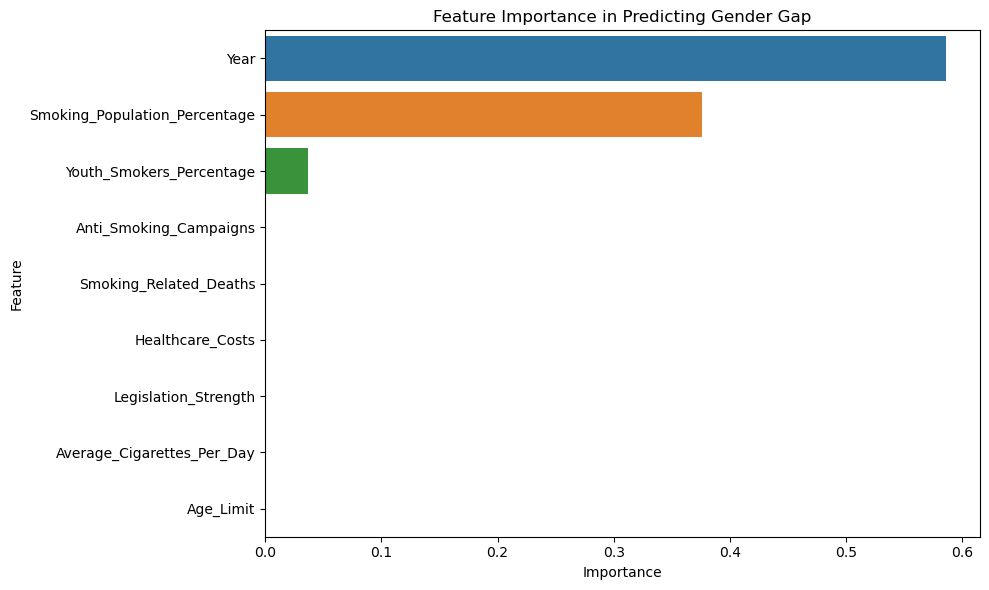

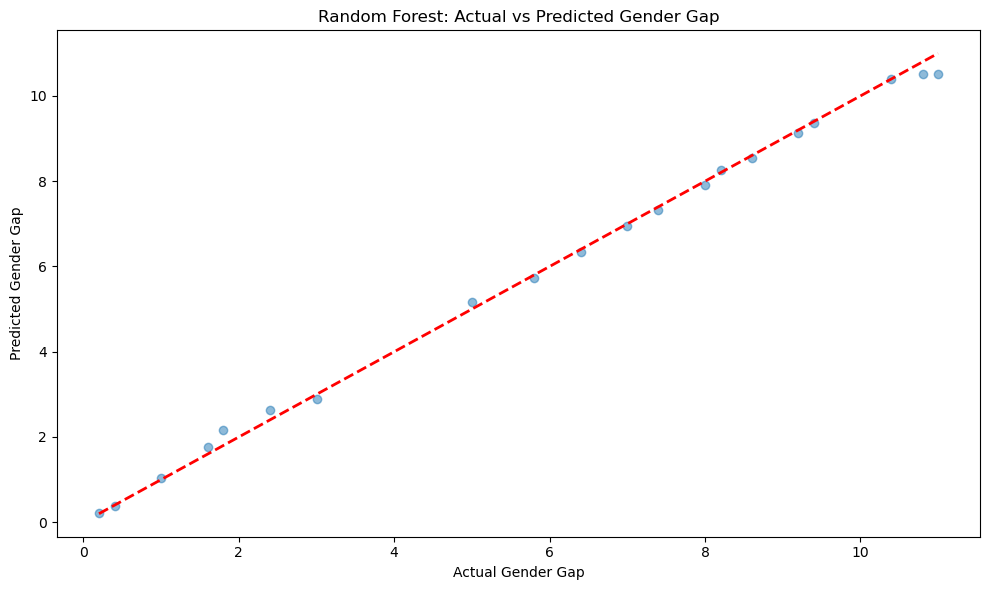

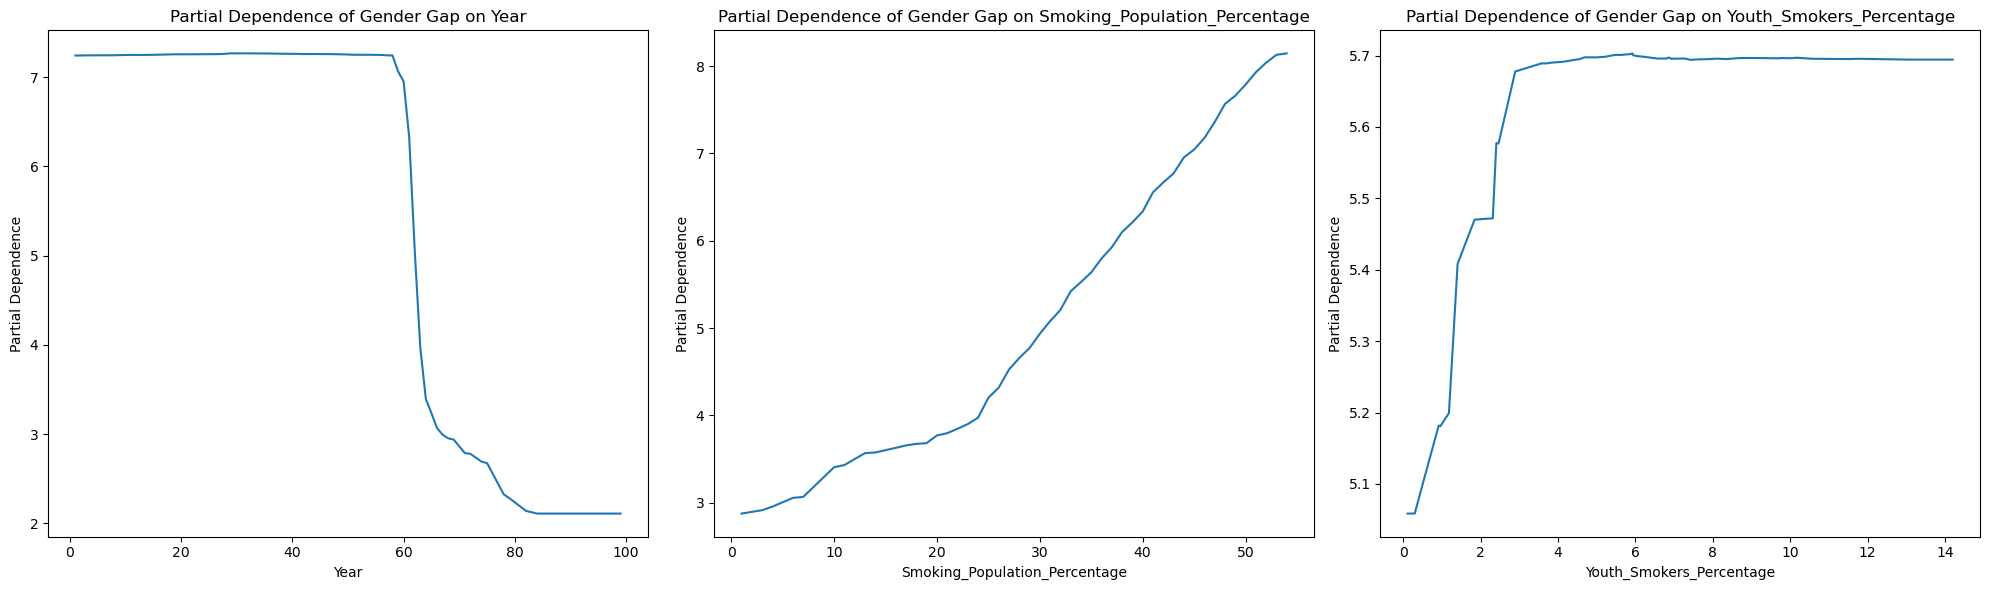

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('world_smoking_history_1924_2023.csv')  # Replace 'your_dataset.csv' with the actual filename

print("Dataset loaded. Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns)

# Convert 'Year' to datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Calculate the Gender Gap if it's not already in the dataset
if 'Gender_Gap' not in df.columns:
    df['Gender_Gap'] = df['Male_Smokers_Percentage'] - df['Female_Smokers_Percentage']

# Prepare the features and target variable
features = ['Year', 'Smoking_Population_Percentage', 'Smoking_Related_Deaths', 
            'Age_Limit', 'Average_Cigarettes_Per_Day', 'Healthcare_Costs', 
            'Anti_Smoking_Campaigns', 'Legislation_Strength', 'Youth_Smokers_Percentage']

# Create a copy of the dataframe with only the features we need
X = df[features].copy()
y = df['Gender_Gap'].copy()

# Convert Year to numeric (years since 1924)
X['Year'] = X['Year'].dt.year - 1924

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Regression Results:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Gender Gap')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Gender Gap')
plt.ylabel('Predicted Gender Gap')
plt.title('Random Forest: Actual vs Predicted Gender Gap')
plt.tight_layout()
plt.show()

# Partial dependence plots for top 3 features
from sklearn.inspection import partial_dependence

top_features = feature_importance['feature'][:3].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, feature in enumerate(top_features):
    pd_results = partial_dependence(rf_model, X_train, features=[feature], kind="average")
    axes[i].plot(pd_results["values"][0], pd_results["average"][0])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Dependence')
    axes[i].set_title(f'Partial Dependence of Gender Gap on {feature}')
plt.tight_layout()
plt.show()